In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import json
import Blueprint as bp

In [2]:
natives_data = pd.read_csv('./natives_pocket_properties_renum.csv',index_col=0)
all_denovo_des = pd.read_csv('../ProteaseAnalysisExp2/Figure3_pocket_volume/final_enhanced_Fig3.csv',index_col=0)
native_ss_strings = pd.read_csv('./nat_ss.csv',index_col=0)
final_set_5ea = pd.read_csv('./final_set_pocket_info.csv',index_col=0)

In [3]:
def get_positions_RIFGEN(fname):
    posfile_dir = "/net/scratch/basantab/20191216_deNovoNTF2DockingBenchmark_RIFDOCK/RIFGEN/posfiles/"
    base = fname.split("/")[-1]
    name = base.split('.')[0]
    nu_fname = posfile_dir+name+'.pos'
    posf = open(nu_fname,'r')
    line = [ i[:-1] for i in posf.readlines() ][0]
    posf.close()
    return [ int(i) for i in line.split() ]

def get_positions_pckt(lines):
    positions = []
    for line in lines:
            if line.startswith('REMARK PDBinfo-LABEL') and ('Pckt' in line): positions += [ int(line.split()[2]) ]
    return positions

In [4]:
def get_coords(fname,is_native_or_tested,**kwargs):
    lines = []
    if 'flines' not in kwargs:
        f = open(fname,'r')
        lines = [ i[:-1] for i in f.readlines() ]
        f.close()
    else: lines = kwargs['flines']
    positions = []
    if is_native_or_tested: positions = get_positions_RIFGEN(fname)
    else: positions = get_positions_pckt(lines)#; print(positions)
    # Now get the actual coordinates:
    pos_dict = {}
    for line in lines:
        if line.startswith('ATOM'):
            position = int(line.split()[5])
            if position in positions:
                atom = line.split()[2]
                AA = line.split()[3]
                if (atom == 'CA'):
                    x = float(line.split()[6])
                    y = float(line.split()[7])
                    z = float(line.split()[8])
                    pos_dict[position] = {'CA':[ x, y, z ]}
                if (atom == 'CB') or ( AA == 'GLY' and atom == '2HA' ):
                    x = float(line.split()[6])
                    y = float(line.split()[7])
                    z = float(line.split()[8])
                    pos_dict[position]['CB'] = [ x, y, z ]
    return pos_dict  

In [5]:
def get_CAcenter_of_mass(coords):
    CA_coords = [ d['CA'] for pos,d in coords.items()]
    return np.average(np.array(CA_coords),axis=0)

In [6]:
def plot_NTF2_pocket_2D(coords,mouth_coords,posn):
    fig, ax = plt.subplots(1, figsize=(10,10),squeeze=True)
    sns.scatterplot([get_CAcenter_of_mass(coords)[0]],[get_CAcenter_of_mass(coords)[1]],marker='D', ax=ax, color='r')
    sns.scatterplot([mouth_coords[0]],[mouth_coords[1]],marker='D', ax=ax, color='b')
    sns.scatterplot([ d['CA'][0] for p,d in coords.items() ],[ d['CA'][1] for p,d in coords.items() ],marker='o', ax=ax, color='g')
    sns.scatterplot([ d['CB'][0] for p,d in coords.items() ],[ d['CB'][1] for p,d in coords.items() ],marker='+', ax=ax, color='k')
    for pos in posn:
        ax.text(coords[pos]['CA'][0], coords[pos]['CA'][1], pos, horizontalalignment='center', size='medium', color='black', weight='semibold')
    plt.show()

In [7]:
def produce_lines(fname):
    f = open(fname,'r')
    lines = [ i[:-1] for i in f.readlines() ]
    f.close()
    return lines

In [8]:
def get_mouth_CAcenter_mass_native_or_tested(mouth_string,flines,coords):
    COM = get_CAcenter_of_mass(coords)
    positions = [ int(i[3:-1]) for i in mouth_string.split('+')[1:]]
    #print(positions)
    pos_list = []
    for line in flines:
        if line.startswith('ATOM'):
            position = int(line.split()[5])
            if position in positions:
                atom = line.split()[2]
                if (atom == 'CA'):
                    x = float(line.split()[6])
                    y = float(line.split()[7])
                    z = float(line.split()[8])
                    pos_list.append([ x, y, z ])
                    
    mouthCOM = np.average(np.array(pos_list),axis=0)
    COM_mouthCOM_hat = (mouthCOM - COM)/np.linalg.norm(mouthCOM - COM)
    # Return the coords of the point 1A away from the pocket CoM in the direction of the mouth CoM
    return COM+COM_mouthCOM_hat

In [9]:
def parse_bp(SS_string):
    data = [ [i+1,'A',ss+'X','.'] for i,ss in enumerate(SS_string) ]
    return bp.Blueprint(data=data)

def get_ss_from_denovo(lines):
    for line in flines:
        if line.startswith('SECSTRUCT'):
            return line.split()[-1]

def get_opening(flines):
    for line in flines:
        if line.startswith('BENTF2DICT'):
            NTF2DICT = (' ').join(line.split()[1:])
            ntf2_dict = json.loads(NTF2DICT)
            return ntf2_dict['Opening']
        
def get_mouth_CAcenter_mass_dn_sheet_plane(flines,coords):
    COM = get_CAcenter_of_mass(coords)
    # Get important strings, i.e., secondary structure string and NTF2 dictionary:
    SECSTRUCT = ''
    NTF2DICT = ''
    pos_dict = {}
    for line in flines:
        if line.startswith('BENTF2DICT'):
            NTF2DICT = (' ').join(line.split()[1:])
            #print(NTF2DICT)
        if line.startswith('SECSTRUCT'):
            SECSTRUCT = line.split()[-1]
        if line.startswith('ATOM'):
            atom = line.split()[2]
            if (atom == 'CA'):
                x = float(line.split()[6])
                y = float(line.split()[7])
                z = float(line.split()[8])
                pos_dict[ int(line.split()[5]) ] =  (x, y, z)
    ntf2_dict = json.loads(NTF2DICT)
    blueprint = parse_bp(SECSTRUCT)
    # Get 2 vectors that define the sheet base plane:
    S1_Cterm_coords = np.array(pos_dict[ blueprint.segment_dict['E1'].bp_data[-1][0] ])
    S1_Nterm_coords = np.array(pos_dict[ blueprint.segment_dict['E1'].bp_data[0][0] ])
    S3_Cterm_coords = np.array(pos_dict[ blueprint.segment_dict['E3'].bp_data[-1][0] ])
    S1_N_to_C = S1_Cterm_coords - S1_Nterm_coords
    S1_N_to_S3_C = S3_Cterm_coords - S1_Nterm_coords
    crossp_upward = np.cross(S1_N_to_C,S1_N_to_S3_C) # This is a vector perpendicular to the sheet base
    crossp_towards_frontalHP = np.cross(S1_N_to_C,crossp_upward) # This is a vector points to the frontal hairpin
    crossp_upward_hat = crossp_upward/np.linalg.norm(crossp_upward)
    crossp_towards_frontalHP_hat = crossp_towards_frontalHP/np.linalg.norm(crossp_towards_frontalHP)
    if ntf2_dict['Opening'] == 'Classic': return crossp_towards_frontalHP_hat+COM
    else: return crossp_upward_hat+COM

In [10]:
def get_alpha_beta_d(CAs,CBs,COMs,mCOMs):
    def get_alpha(CA,CB,COM):
        len_CA_CB = np.linalg.norm(CB-CA)
        len_COM_CA = np.linalg.norm(COM-CA)
        return np.degrees( np.arccos( np.dot(CB-CA,COM-CA)/(len_COM_CA*len_CA_CB) ) )
    def get_beta(CA,mCOM,COM):
        # len_COM_mCOM = np.linalg.norm(mCOM-COM) # It's always 1 by definition in get_mouth_CAcenter_mass_*
        len_COM_CA = np.linalg.norm(COM-CA)
        result = np.degrees( np.arccos( np.clip(np.dot(mCOM-COM,COM-CA)/(len_COM_CA*1),-1,1) ) ) # *1 bc len_COM_mCOM == 1
        return result
    def get_d(CA,COM):
        return np.linalg.norm(COM-CA)
    main_v = np.array([ [get_alpha(CA,CB,COM),get_beta(CA,mCOM,COM),get_d(CA,COM)] for CA,CB,COM,mCOM in zip(CAs,CBs,COMs,mCOMs) ])
    return {'alpha':main_v[:,0],'beta':main_v[:,1],'d':main_v[:,2]}

In [11]:
RIFDOCKED_denovos = all_denovo_des.loc[all_denovo_des.nuVolume > 30]\
                     .loc[all_denovo_des.is_stable == 1].index
natives = natives_data.index
denovos_all = all_denovo_des.index
final_set = final_set_5ea.index

In [12]:
test = get_coords(all_denovo_des.index[0],False,flines = produce_lines(all_denovo_des.index[0]))
get_CAcenter_of_mass(test)

array([11.55534783,  2.49895652, -0.02426087])

+ALA113A+ALA138A+ARG71A+ASN67A+ASP105A+GLU49A+LEU104A+LEU68A+LYS74A+PRO139A+PRO48A+SER70A+TYR103A+TYR64A


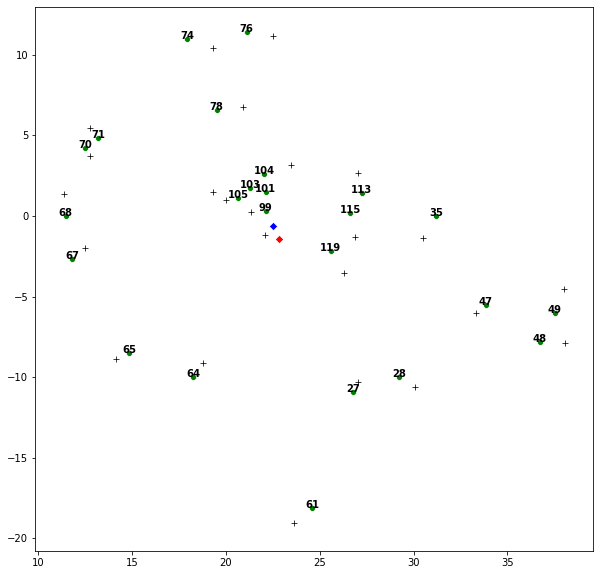

In [13]:
test = get_coords('/net/scratch/basantab/natives_renum/d1hkxa__0001.pdb',True,flines = produce_lines(natives[0]))
mouth_string = natives_data.loc['/net/scratch/basantab/natives_renum/d1hkxa__0001.pdb'].MouthResidueNameList
print(mouth_string)
mouth_coords = get_mouth_CAcenter_mass_native_or_tested(mouth_string,produce_lines('/net/scratch/basantab/natives_renum/d1hkxa__0001.pdb'),test)
posn = [ key for key in test]
plot_NTF2_pocket_2D(test,mouth_coords,posn)

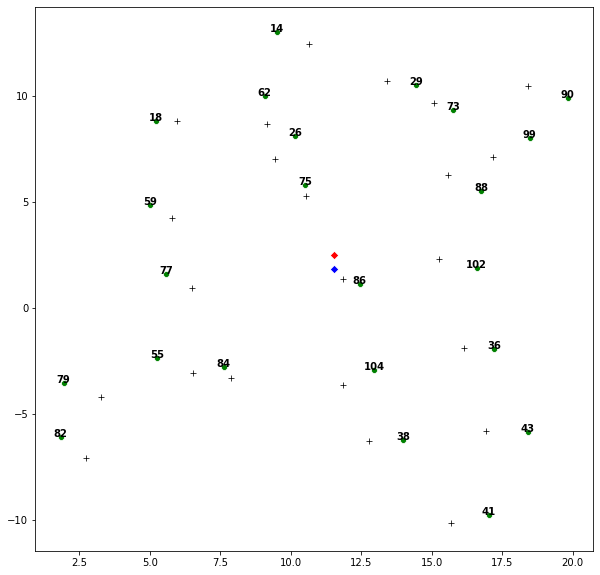

In [14]:
flines = produce_lines(all_denovo_des.index[0])
test = get_coords(all_denovo_des.index[0],False,flines = flines)
mouth_coords = get_mouth_CAcenter_mass_dn_sheet_plane(flines,test)
posn = [ key for key in test]
plot_NTF2_pocket_2D(test,mouth_coords,posn)

In [15]:
'''
found = False
for name in all_denovo_des.index:
    lines = produce_lines(name)
    for line in lines:
        if line.startswith('BENTF2DICT'):
            NTF2DICT = (' ').join(line.split()[1:])
            ntf2_dict = json.loads(NTF2DICT)
            if ntf2_dict['Opening'] != 'Classic': print(name); found = True
    if found: break
'''

"\nfound = False\nfor name in all_denovo_des.index:\n    lines = produce_lines(name)\n    for line in lines:\n        if line.startswith('BENTF2DICT'):\n            NTF2DICT = (' ').join(line.split()[1:])\n            ntf2_dict = json.loads(NTF2DICT)\n            if ntf2_dict['Opening'] != 'Classic': print(name); found = True\n    if found: break\n"

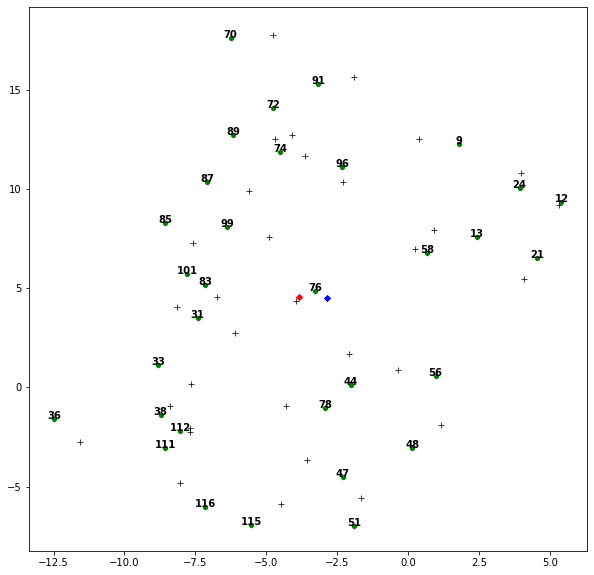

In [15]:
fname = '/home/basantab/NTF2_project/20180411_designBBsInHyak/finished_designs_by_length/117/CJQDGLWZ_BasicBeNTF2_designed_0000.pdb'
flines = produce_lines(fname)
test = get_coords(fname,False,flines = flines)
mouth_coords = get_mouth_CAcenter_mass_dn_sheet_plane(flines,test)
posn = [ key for key in test]
plot_NTF2_pocket_2D(test,mouth_coords,posn)

In [17]:
# Construct dictionary for natives:
# Start with natives and ~700 verified de novo
'''
vector_dictionaries = []

for n,idx in enumerate(natives):
    flines = produce_lines(idx)
    coords = get_coords(idx,True,flines=flines )
    COM = get_CAcenter_of_mass(coords)
    mouth_string = natives_data.loc[idx].MouthResidueNameList
    mouth_point = get_mouth_CAcenter_mass_native_or_tested(mouth_string,flines,coords)
    ss_string = native_ss_strings.loc[idx]['ss']
    ss_dict = { (i+1):ss for i,ss in enumerate(ss_string)}
    vector_dictionaries += [{ 'pos':i[0], 'CA':i[1]['CA'], 'CB':i[1]['CB'], 'fname':idx,\
                                  'COM':COM, 'mouthPoint':mouth_point,\
                                  'class':'nat','opening':'nat','SS':ss_dict[i[0]]} for i in coords.items()]

for n,idx in enumerate(RIFDOCKED_denovos):
    flines = produce_lines(idx)
    coords = get_coords(idx,True,flines=flines )
    COM = get_CAcenter_of_mass(coords)
    mouth_point = get_mouth_CAcenter_mass_dn_sheet_plane(flines,coords)
    ss_string = get_ss_from_denovo(flines)
    ss_dict = { (i+1):ss for i,ss in enumerate(ss_string)}
    vector_dictionaries += [{ 'pos':i[0], 'CA':i[1]['CA'], 'CB':i[1]['CB'], 'fname':idx,\
                                  'COM':COM, 'mouthPoint':mouth_point,\
                                  'class':'dn_docked','opening':get_opening(flines),'SS':ss_dict[i[0]]} for i in coords.items()]

for n,idx in enumerate(denovos_all):
    flines = produce_lines(idx)
    coords = get_coords(idx,False,flines=flines )
    COM = get_CAcenter_of_mass(coords)
    mouth_point = get_mouth_CAcenter_mass_dn_sheet_plane(flines,coords)
    ss_string = get_ss_from_denovo(flines)
    ss_dict = { (i+1):ss for i,ss in enumerate(ss_string)}
    vector_dictionaries += [{ 'pos':i[0], 'CA':i[1]['CA'], 'CB':i[1]['CB'], 'fname':idx,\
                                  'COM':COM, 'mouthPoint':mouth_point,\
                                  'class':'dn_rd2','opening':get_opening(flines),'SS':ss_dict[i[0]]} for i in coords.items()]

for n,idx in enumerate(final_set):
    flines = produce_lines(idx)
    coords = get_coords(idx,False,flines=flines )
    COM = get_CAcenter_of_mass(coords)
    mouth_point = get_mouth_CAcenter_mass_dn_sheet_plane(flines,coords)
    ss_string = get_ss_from_denovo(flines)
    ss_dict = { (i+1):ss for i,ss in enumerate(ss_string)}
    vector_dictionaries += [{ 'pos':i[0], 'CA':i[1]['CA'], 'CB':i[1]['CB'], 'fname':idx,\
                                  'COM':COM, 'mouthPoint':mouth_point,\
                                  'class':'final_set','opening':get_opening(flines),'SS':ss_dict[i[0]]} for i in coords.items()]
df = pd.DataFrame.from_dict({i:j for i,j in enumerate(vector_dictionaries)},orient='index')
df.to_csv('./positions_df.csv')
'''

"\nvector_dictionaries = []\n\nfor n,idx in enumerate(natives):\n    flines = produce_lines(idx)\n    coords = get_coords(idx,True,flines=flines )\n    COM = get_CAcenter_of_mass(coords)\n    mouth_string = natives_data.loc[idx].MouthResidueNameList\n    mouth_point = get_mouth_CAcenter_mass_native_or_tested(mouth_string,flines,coords)\n    ss_string = native_ss_strings.loc[idx]['ss']\n    ss_dict = { (i+1):ss for i,ss in enumerate(ss_string)}\n    vector_dictionaries += [{ 'pos':i[0], 'CA':i[1]['CA'], 'CB':i[1]['CB'], 'fname':idx,                                  'COM':COM, 'mouthPoint':mouth_point,                                  'class':'nat','opening':'nat','SS':ss_dict[i[0]]} for i in coords.items()]\n\nfor n,idx in enumerate(RIFDOCKED_denovos):\n    flines = produce_lines(idx)\n    coords = get_coords(idx,True,flines=flines )\n    COM = get_CAcenter_of_mass(coords)\n    mouth_point = get_mouth_CAcenter_mass_dn_sheet_plane(flines,coords)\n    ss_string = get_ss_from_denovo(flines

In [16]:
def arreval(s):
    good_s = s.replace('[','').replace(']','')
    return np.fromstring(good_s,dtype=float, count=3, sep=' ')

df = pd.read_csv('./positions_df.csv',index_col=0, converters={'CA': eval,'CB': eval,'COM':arreval, 'mouthPoint':arreval})
df.head()

,pos,CA,CB,fname,COM,mouthPoint,class,opening,SS,apha,beta,d,t11,t12,t13,t21,t22,t23
0,20,"[23.504, -12.209, 5.907]","[23.241, -10.856, 6.58]",/net/scratch/basantab/natives_renum/d1gy6a__00...,"[23.4168125, -2.68453125, 13.74321875]","[23.91486205, -1.86303923, 14.02088312]",nat,nat,H,16.027211,90.0,12.334076,0.087188,-9.524469,-7.836219,-0.673862,-8.992961,-7.440883
1,38,"[31.519, 0.928, 7.697]","[31.138, 2.382, 8.04]",/net/scratch/basantab/natives_renum/d1gy6a__00...,"[23.4168125, -2.68453125, 13.74321875]","[23.91486205, -1.86303923, 14.02088312]",nat,nat,E,90.317903,90.0,10.735576,8.102187,3.612531,-6.046219,7.223138,4.245039,-5.980883
2,39,"[31.346, -1.697, 10.434]","[31.748, -3.119, 10.019]",/net/scratch/basantab/natives_renum/d1gy6a__00...,"[23.4168125, -2.68453125, 13.74321875]","[23.91486205, -1.86303923, 14.02088312]",nat,nat,E,103.756124,90.0,8.648593,7.929188,0.987531,-3.309219,7.833138,-1.255961,-4.001883
3,40,"[31.497, -0.468, 14.033]","[32.015, -1.661, 14.846]",/net/scratch/basantab/natives_renum/d1gy6a__00...,"[23.4168125, -2.68453125, 13.74321875]","[23.91486205, -1.86303923, 14.02088312]",nat,nat,L,97.942375,90.0,8.383699,8.080188,2.216531,0.289781,8.100138,0.202039,0.825117
4,41,"[33.349, 2.643, 12.909]","[33.718, 2.912, 13.897]",/net/scratch/basantab/natives_renum/d1gy6a__00...,"[23.4168125, -2.68453125, 13.74321875]","[23.91486205, -1.86303923, 14.02088312]",nat,nat,L,110.330956,90.0,11.301631,9.932187,5.327531,-0.834219,9.803138,4.775039,-0.123883


In [17]:
native_entries = df.loc[df['class'] == 'nat']
nCAs = np.array([np.array(i) for i in native_entries.CA.values])
nCBs = np.array([np.array(i) for i in native_entries.CB.values])
nCOMs = np.array([np.array(i) for i in native_entries.COM.values])
nmCOMs = np.array([np.array(i) for i in native_entries.mouthPoint.values])
nat_dict_to_plot = get_alpha_beta_d(nCAs,nCBs,nCOMs,nmCOMs)

In [18]:
denovo_docked_entries = df.loc[df['class'] == 'dn_docked']
dndckCAs = np.array([np.array(i) for i in denovo_docked_entries.CA.values])
dndckCBs = np.array([np.array(i) for i in denovo_docked_entries.CB.values])
dndckCOMs = np.array([np.array(i) for i in denovo_docked_entries.COM.values])
dndckmCOMs = np.array([np.array(i) for i in denovo_docked_entries.mouthPoint.values])
dndck_dict_to_plot = get_alpha_beta_d(dndckCAs,dndckCBs,dndckCOMs,dndckmCOMs)

In [19]:
denovo_rd2_entries = df.loc[df['class'] == 'dn_rd2']
dnrd2CAs = np.array([np.array(i) for i in denovo_rd2_entries.CA.values])
dnrd2CBs = np.array([np.array(i) for i in denovo_rd2_entries.CB.values])
dnrd2COMs = np.array([np.array(i) for i in denovo_rd2_entries.COM.values])
dnrd2mCOMs = np.array([np.array(i) for i in denovo_rd2_entries.mouthPoint.values])
dnrd2_dict_to_plot = get_alpha_beta_d(dnrd2CAs,dnrd2CBs,dnrd2COMs,dnrd2mCOMs)

In [20]:
denovo_final_entries = df.loc[df['class'] == 'final_set']
dnfnCAs = np.array([np.array(i) for i in denovo_final_entries.CA.values])
dnfnCBs = np.array([np.array(i) for i in denovo_final_entries.CB.values])
dnfnCOMs = np.array([np.array(i) for i in denovo_final_entries.COM.values])
dnfnmCOMs = np.array([np.array(i) for i in denovo_final_entries.mouthPoint.values])
dnfn_dict_to_plot = get_alpha_beta_d(dnfnCAs,dnfnCBs,dnfnCOMs,dnfnmCOMs)

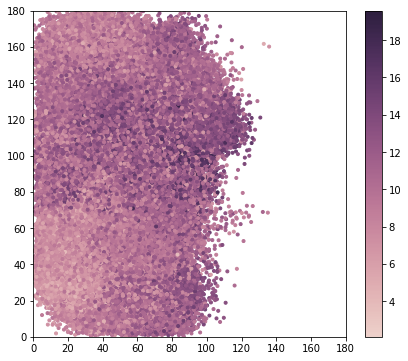

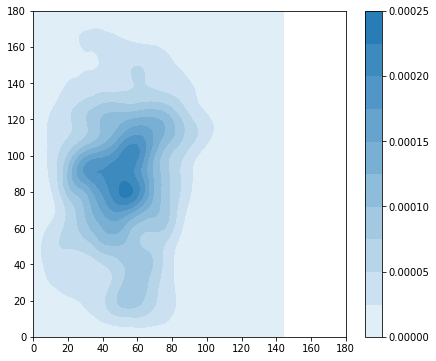

In [23]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(1,figsize=(7,6))
points = plt.scatter(dnfn_dict_to_plot['alpha'],dnfn_dict_to_plot['beta'],c=dnfn_dict_to_plot['d'],cmap=cmap,marker='.')
f.colorbar(points)
plt.ylim(0,180)
plt.xlim(0,180)
plt.show()
f, ax = plt.subplots(1,figsize=(7,6))
sns.kdeplot(dnfn_dict_to_plot['alpha'],dnfn_dict_to_plot['beta'],shade=True,cbar=True,)
plt.ylim(0,180)
plt.xlim(0,180)
plt.show()

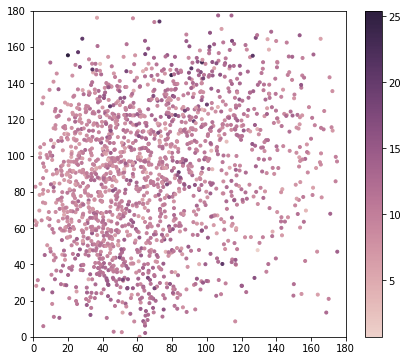

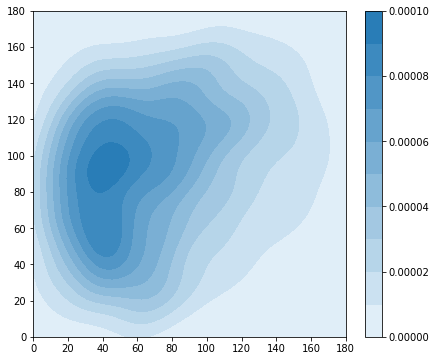

In [24]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(1,figsize=(7,6))
points = plt.scatter(nat_dict_to_plot['alpha'],nat_dict_to_plot['beta'],c=nat_dict_to_plot['d'],cmap=cmap,marker='.')
f.colorbar(points)
plt.ylim(0,180)
plt.xlim(0,180)
plt.show()
f, ax = plt.subplots(1,figsize=(7,6))
sns.kdeplot(nat_dict_to_plot['alpha'],nat_dict_to_plot['beta'],shade=True,cbar=True,)
plt.ylim(0,180)
plt.xlim(0,180)
plt.show()

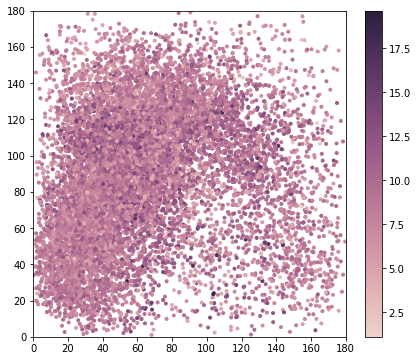

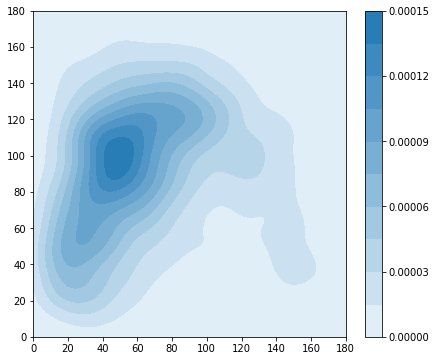

In [25]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(1,figsize=(7,6))
points = plt.scatter(dndck_dict_to_plot['alpha'],dndck_dict_to_plot['beta'],c=dndck_dict_to_plot['d']\
                     ,cmap=cmap,marker='.')
f.colorbar(points)
plt.ylim(0,180)
plt.xlim(0,180)
plt.show()
f, ax = plt.subplots(1,figsize=(7,6))
sns.kdeplot(dndck_dict_to_plot['alpha'],dndck_dict_to_plot['beta'],shade=True,cbar=True,)
plt.ylim(0,180)
plt.xlim(0,180)
plt.show()

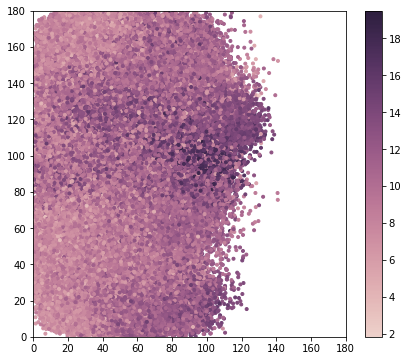

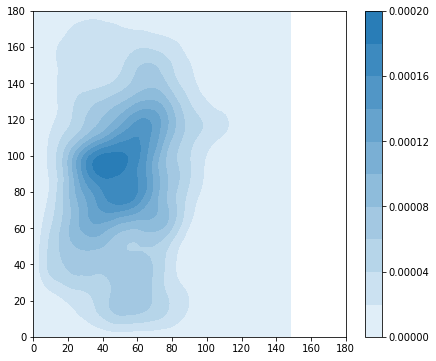

In [26]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(1,figsize=(7,6))
points = plt.scatter(dnrd2_dict_to_plot['alpha'],dnrd2_dict_to_plot['beta'],c=dnrd2_dict_to_plot['d']\
                     ,cmap=cmap,marker='.')
f.colorbar(points)
plt.ylim(0,180)
plt.xlim(0,180)
plt.show()
f, ax = plt.subplots(1,figsize=(7,6))
sns.kdeplot(dnrd2_dict_to_plot['alpha'],dnrd2_dict_to_plot['beta'],shade=True,cbar=True,)
plt.ylim(0,180)
plt.xlim(0,180)
plt.show()

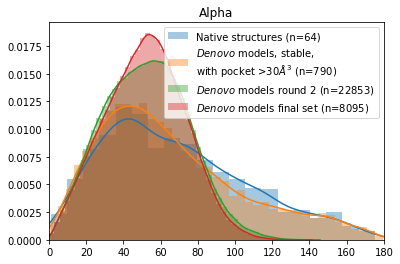

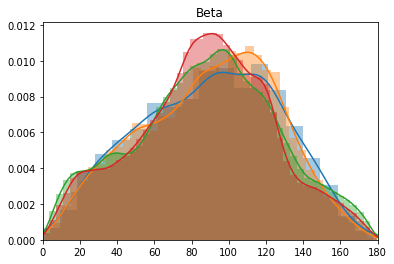

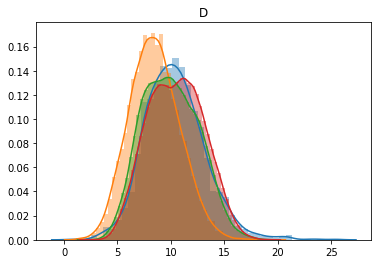

In [36]:
sns.distplot(nat_dict_to_plot['alpha'],label='Native structures (n=64)')
sns.distplot(dndck_dict_to_plot['alpha'],label=r'''$De novo$ models, stable,
with pocket >30$\AA^3$ (n=790)''')
sns.distplot(dnrd2_dict_to_plot['alpha'],label=r'$De novo$ models round 2 (n=22853)')
sns.distplot(dnfn_dict_to_plot['alpha'],label=r'$De novo$ models final set (n=8095)')
plt.legend()
plt.xlim(0,180)
plt.title('Alpha')
plt.show()

sns.distplot(nat_dict_to_plot['beta'],label='Native structures (n=64)')
sns.distplot(dndck_dict_to_plot['beta'],label=r'''$De novo$ models, stable,
with pocket >30$\AA^3$ (n=790)''')
sns.distplot(dnrd2_dict_to_plot['beta'],label=r'$De novo$ models round 2 (n=22853)')
sns.distplot(dnfn_dict_to_plot['beta'],label=r'$De novo$ models final set (n=8095)')
plt.xlim(0,180)
plt.title('Beta')
plt.show()

sns.distplot(nat_dict_to_plot['d'],label='Native structures (n=64)')
sns.distplot(dndck_dict_to_plot['d'],label='''$De novo$ models, stable,
with pocket >30$\AA^3$ (n=790)''')
sns.distplot(dnrd2_dict_to_plot['d'],label=r'$De novo$ models round 2 (n=22853)')
sns.distplot(dnfn_dict_to_plot['d'],label=r'$De novo$ models final set (n=8095)')
plt.title('D')
plt.show()

In [28]:
'''
# Add alpha, beta and d columns to main data frame:
CAs = np.array([np.array(i) for i in df.CA.values])
CBs = np.array([np.array(i) for i in df.CB.values])
COMs = np.array([np.array(i) for i in df.COM.values])
mCOMs = np.array([np.array(i) for i in df.mouthPoint.values])
alpha_beta_d = get_alpha_beta_d(CAs,CBs,COMs,COMs)
'''

'\n# Add alpha, beta and d columns to main data frame:\nCAs = np.array([np.array(i) for i in df.CA.values])\nCBs = np.array([np.array(i) for i in df.CB.values])\nCOMs = np.array([np.array(i) for i in df.COM.values])\nmCOMs = np.array([np.array(i) for i in df.mouthPoint.values])\nalpha_beta_d = get_alpha_beta_d(CAs,CBs,COMs,COMs)\n'

In [29]:
'''
df['apha'] = alpha_beta_d['alpha']
df['beta'] = alpha_beta_d['beta']
df['d'] = alpha_beta_d['d']
'''

"\ndf['apha'] = alpha_beta_d['alpha']\ndf['beta'] = alpha_beta_d['beta']\ndf['d'] = alpha_beta_d['d']\n"

In [30]:
'''
df['t11'] = (CAs - COMs)[:,0]
df['t12'] = (CAs - COMs)[:,1]
df['t13'] = (CAs - COMs)[:,2]
df['t21'] = (CBs - mCOMs)[:,0]
df['t22'] = (CBs - mCOMs)[:,1]
df['t23'] = (CBs - mCOMs)[:,2]
'''

"\ndf['t11'] = (CAs - COMs)[:,0]\ndf['t12'] = (CAs - COMs)[:,1]\ndf['t13'] = (CAs - COMs)[:,2]\ndf['t21'] = (CBs - mCOMs)[:,0]\ndf['t22'] = (CBs - mCOMs)[:,1]\ndf['t23'] = (CBs - mCOMs)[:,2]\n"

In [31]:
'''
t11_bins = np.linspace(np.min(df['t11'].values),np.max(df['t11'].values),10)
t12_bins = np.linspace(np.min(df['t12'].values),np.max(df['t12'].values),10)
t13_bins = np.linspace(np.min(df['t13'].values),np.max(df['t13'].values),10)
t21_bins = np.linspace(np.min(df['t21'].values),np.max(df['t21'].values),10)
t22_bins = np.linspace(np.min(df['t22'].values),np.max(df['t22'].values),10)
t23_bins = np.linspace(np.min(df['t23'].values),np.max(df['t23'].values),10)
structures = set(df['fname'].values)
new_dict_features = {}
for s in structures:
    this_s_data = df.loc[df['fname'] == s]
    t11_hist = np.histogram(this_s_data['t11'].values,bins=t11_bins,density=True)[0]
    t12_hist = np.histogram(this_s_data['t12'].values,bins=t12_bins,density=True)[0]
    t13_hist = np.histogram(this_s_data['t13'].values,bins=t13_bins,density=True)[0]
    t21_hist = np.histogram(this_s_data['t21'].values,bins=t21_bins,density=True)[0]
    t22_hist = np.histogram(this_s_data['t22'].values,bins=t22_bins,density=True)[0]
    t23_hist = np.histogram(this_s_data['t23'].values,bins=t23_bins,density=True)[0]
    Hf = len(this_s_data.loc[this_s_data.SS == 'H'].index)/len(this_s_data.index)
    Lf = len(this_s_data.loc[this_s_data.SS == 'L'].index)/len(this_s_data.index)
    Ef = len(this_s_data.loc[this_s_data.SS == 'E'].index)/len(this_s_data.index)
    
    new_dict_features[s] = { 't11_hist'+str(n) : i for n,i in enumerate(t11_hist) }
    new_dict_features[s].update( { 't12_hist'+str(n) : i for n,i in enumerate(t12_hist) } )
    new_dict_features[s].update( { 't13_hist'+str(n) : i for n,i in enumerate(t13_hist) } )
    new_dict_features[s].update( { 't21_hist'+str(n) : i for n,i in enumerate(t21_hist) } )
    new_dict_features[s].update( { 't22_hist'+str(n) : i for n,i in enumerate(t22_hist) } )
    new_dict_features[s].update( { 't23_hist'+str(n) : i for n,i in enumerate(t23_hist) } )
    new_dict_features[s].update( {'Hf':Hf, 'Lf':Lf, 'Ef':Ef} )
pocket_features = pd.DataFrame.from_dict(new_dict_features,orient='index')
pocket_features['class'] = np.array( [ df.loc[df['fname'] == i]['class'].values[0] for i in pocket_features.index] )
pocket_features['opening'] = np.array( [ df.loc[df['fname'] == i]['opening'].values[0] for i in pocket_features.index] )
pocket_features.to_csv('./pocket_features_df.csv')
'''

"\nt11_bins = np.linspace(np.min(df['t11'].values),np.max(df['t11'].values),10)\nt12_bins = np.linspace(np.min(df['t12'].values),np.max(df['t12'].values),10)\nt13_bins = np.linspace(np.min(df['t13'].values),np.max(df['t13'].values),10)\nt21_bins = np.linspace(np.min(df['t21'].values),np.max(df['t21'].values),10)\nt22_bins = np.linspace(np.min(df['t22'].values),np.max(df['t22'].values),10)\nt23_bins = np.linspace(np.min(df['t23'].values),np.max(df['t23'].values),10)\nstructures = set(df['fname'].values)\nnew_dict_features = {}\nfor s in structures:\n    this_s_data = df.loc[df['fname'] == s]\n    t11_hist = np.histogram(this_s_data['t11'].values,bins=t11_bins,density=True)[0]\n    t12_hist = np.histogram(this_s_data['t12'].values,bins=t12_bins,density=True)[0]\n    t13_hist = np.histogram(this_s_data['t13'].values,bins=t13_bins,density=True)[0]\n    t21_hist = np.histogram(this_s_data['t21'].values,bins=t21_bins,density=True)[0]\n    t22_hist = np.histogram(this_s_data['t22'].values,bin

In [32]:
pocket_features = pd.read_csv('./pocket_features_df.csv',index_col=0)

In [33]:
'''
df_no_loops = df.loc[df.SS != 'L']
df_no_loops.to_csv('./positions_df_no_loops.csv')
'''
df_no_loops = pd.read_csv('./positions_df_no_loops.csv',index_col=0, converters={'CA': eval,'CB': eval,'COM':arreval, 'mouthPoint':arreval})

In [34]:
'''
t11_bins = np.linspace(np.min(df['t11'].values),np.max(df['t11'].values),10)
t12_bins = np.linspace(np.min(df['t12'].values),np.max(df['t12'].values),10)
t13_bins = np.linspace(np.min(df['t13'].values),np.max(df['t13'].values),10)
t21_bins = np.linspace(np.min(df['t21'].values),np.max(df['t21'].values),10)
t22_bins = np.linspace(np.min(df['t22'].values),np.max(df['t22'].values),10)
t23_bins = np.linspace(np.min(df['t23'].values),np.max(df['t23'].values),10)
structures = set(df['fname'].values)
new_dict_features = {}
for s in structures:
    this_s_data = df_no_loops.loc[df_no_loops['fname'] == s]
    t11_hist = np.histogram(this_s_data['t11'].values,bins=t11_bins,density=True)[0]
    t12_hist = np.histogram(this_s_data['t12'].values,bins=t12_bins,density=True)[0]
    t13_hist = np.histogram(this_s_data['t13'].values,bins=t13_bins,density=True)[0]
    t21_hist = np.histogram(this_s_data['t21'].values,bins=t21_bins,density=True)[0]
    t22_hist = np.histogram(this_s_data['t22'].values,bins=t22_bins,density=True)[0]
    t23_hist = np.histogram(this_s_data['t23'].values,bins=t23_bins,density=True)[0]
    Hf = len(this_s_data.loc[this_s_data.SS == 'H'].index)/len(this_s_data.index)
    Lf = len(this_s_data.loc[this_s_data.SS == 'L'].index)/len(this_s_data.index)
    Ef = len(this_s_data.loc[this_s_data.SS == 'E'].index)/len(this_s_data.index)
    
    new_dict_features[s] = { 't11_hist'+str(n) : i for n,i in enumerate(t11_hist) }
    new_dict_features[s].update( { 't12_hist'+str(n) : i for n,i in enumerate(t12_hist) } )
    new_dict_features[s].update( { 't13_hist'+str(n) : i for n,i in enumerate(t13_hist) } )
    new_dict_features[s].update( { 't21_hist'+str(n) : i for n,i in enumerate(t21_hist) } )
    new_dict_features[s].update( { 't22_hist'+str(n) : i for n,i in enumerate(t22_hist) } )
    new_dict_features[s].update( { 't23_hist'+str(n) : i for n,i in enumerate(t23_hist) } )
    new_dict_features[s].update( {'Hf':Hf, 'Lf':Lf, 'Ef':Ef, 'class':this_s_data['class'].iloc[0], 'opening':this_s_data['opening'].iloc[0]} )
    
pocket_features = pd.DataFrame.from_dict(new_dict_features,orient='index')
pocket_features.to_csv('./pocket_features_df_no_loops.csv')
'''
pocket_feature_no_loops = pd.read_csv('./pocket_features_df_no_loops.csv',index_col=0)


In [35]:
native_entries = df_no_loops.loc[df_no_loops['class'] == 'nat']
nCAs = np.array([np.array(i) for i in native_entries.CA.values])
nCBs = np.array([np.array(i) for i in native_entries.CB.values])
nCOMs = np.array([np.array(i) for i in native_entries.COM.values])
nmCOMs = np.array([np.array(i) for i in native_entries.mouthPoint.values])
nat_dict_to_plot = get_alpha_beta_d(nCAs,nCBs,nCOMs,nmCOMs)

denovo_docked_entries = df_no_loops.loc[df_no_loops['class'] == 'dn_docked']
dndckCAs = np.array([np.array(i) for i in denovo_docked_entries.CA.values])
dndckCBs = np.array([np.array(i) for i in denovo_docked_entries.CB.values])
dndckCOMs = np.array([np.array(i) for i in denovo_docked_entries.COM.values])
dndckmCOMs = np.array([np.array(i) for i in denovo_docked_entries.mouthPoint.values])
dndck_dict_to_plot = get_alpha_beta_d(dndckCAs,dndckCBs,dndckCOMs,dndckmCOMs)

denovo_rd2_entries = df_no_loops.loc[df_no_loops['class'] == 'dn_rd2']
dnrd2CAs = np.array([np.array(i) for i in denovo_rd2_entries.CA.values])
dnrd2CBs = np.array([np.array(i) for i in denovo_rd2_entries.CB.values])
dnrd2COMs = np.array([np.array(i) for i in denovo_rd2_entries.COM.values])
dnrd2mCOMs = np.array([np.array(i) for i in denovo_rd2_entries.mouthPoint.values])
dnrd2_dict_to_plot = get_alpha_beta_d(dnrd2CAs,dnrd2CBs,dnrd2COMs,dnrd2mCOMs)

denovo_final_entries = df_no_loops.loc[df_no_loops['class'] == 'final_set']
dnfnCAs = np.array([np.array(i) for i in denovo_final_entries.CA.values])
dnfnCBs = np.array([np.array(i) for i in denovo_final_entries.CB.values])
dnfnCOMs = np.array([np.array(i) for i in denovo_final_entries.COM.values])
dnfnmCOMs = np.array([np.array(i) for i in denovo_final_entries.mouthPoint.values])
dnfn_dict_to_plot = get_alpha_beta_d(dnfnCAs,dnfnCBs,dnfnCOMs,dnfnmCOMs)

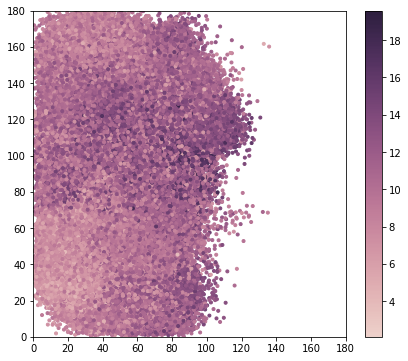

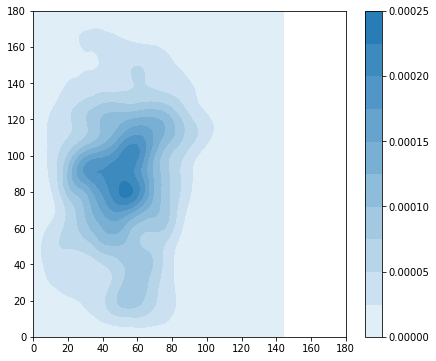

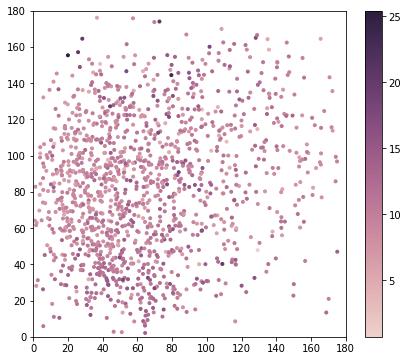

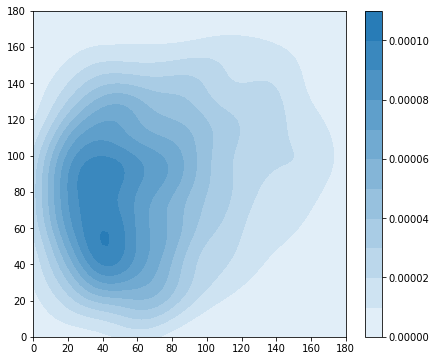

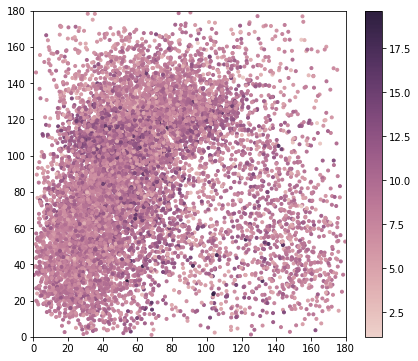

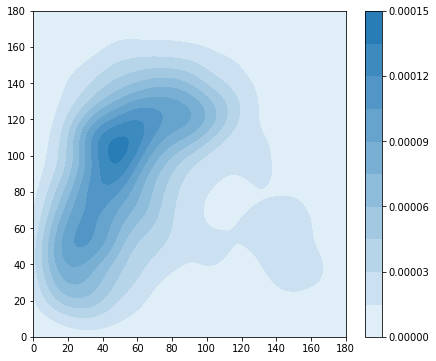

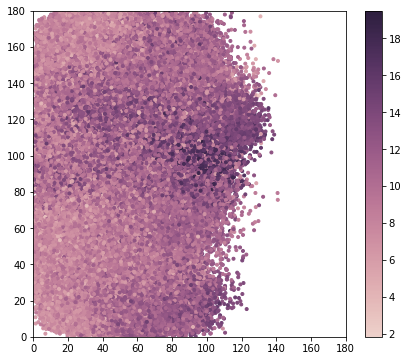

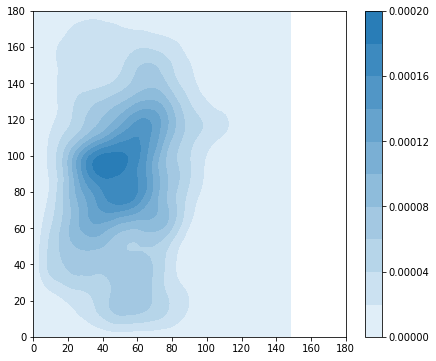

In [36]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(1,figsize=(7,6))
points = plt.scatter(dnfn_dict_to_plot['alpha'],dnfn_dict_to_plot['beta'],c=dnfn_dict_to_plot['d'],cmap=cmap,marker='.')
f.colorbar(points)
plt.ylim(0,180)
plt.xlim(0,180)
plt.show()
f, ax = plt.subplots(1,figsize=(7,6))
sns.kdeplot(dnfn_dict_to_plot['alpha'],dnfn_dict_to_plot['beta'],shade=True,cbar=True,)
plt.ylim(0,180)
plt.xlim(0,180)
plt.show()

cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(1,figsize=(7,6))
points = plt.scatter(nat_dict_to_plot['alpha'],nat_dict_to_plot['beta'],c=nat_dict_to_plot['d'],cmap=cmap,marker='.')
f.colorbar(points)
plt.ylim(0,180)
plt.xlim(0,180)
plt.show()
f, ax = plt.subplots(1,figsize=(7,6))
sns.kdeplot(nat_dict_to_plot['alpha'],nat_dict_to_plot['beta'],shade=True,cbar=True,)
plt.ylim(0,180)
plt.xlim(0,180)
plt.show()

cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(1,figsize=(7,6))
points = plt.scatter(dndck_dict_to_plot['alpha'],dndck_dict_to_plot['beta'],c=dndck_dict_to_plot['d']\
                     ,cmap=cmap,marker='.')
f.colorbar(points)
plt.ylim(0,180)
plt.xlim(0,180)
plt.show()
f, ax = plt.subplots(1,figsize=(7,6))
sns.kdeplot(dndck_dict_to_plot['alpha'],dndck_dict_to_plot['beta'],shade=True,cbar=True,)
plt.ylim(0,180)
plt.xlim(0,180)
plt.show()

cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(1,figsize=(7,6))
points = plt.scatter(dnrd2_dict_to_plot['alpha'],dnrd2_dict_to_plot['beta'],c=dnrd2_dict_to_plot['d']\
                     ,cmap=cmap,marker='.')
f.colorbar(points)
plt.ylim(0,180)
plt.xlim(0,180)
plt.show()
f, ax = plt.subplots(1,figsize=(7,6))
sns.kdeplot(dnrd2_dict_to_plot['alpha'],dnrd2_dict_to_plot['beta'],shade=True,cbar=True,)
plt.ylim(0,180)
plt.xlim(0,180)
plt.show()

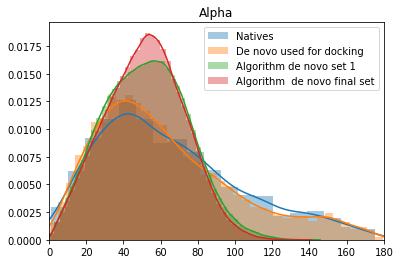

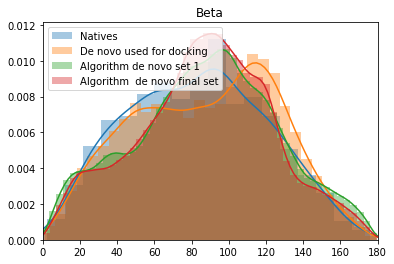

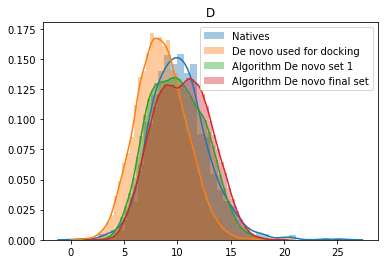

In [37]:
sns.distplot(nat_dict_to_plot['alpha'],label='Natives')
sns.distplot(dndck_dict_to_plot['alpha'],label='De novo used for docking')
sns.distplot(dnrd2_dict_to_plot['alpha'],label='Algorithm de novo set 1')
sns.distplot(dnfn_dict_to_plot['alpha'],label='Algorithm  de novo final set')
plt.legend()
plt.xlim(0,180)
plt.title('Alpha')
plt.show()

sns.distplot(nat_dict_to_plot['beta'],label='Natives')
sns.distplot(dndck_dict_to_plot['beta'],label='De novo used for docking')
sns.distplot(dnrd2_dict_to_plot['beta'],label='Algorithm de novo set 1')
sns.distplot(dnfn_dict_to_plot['beta'],label='Algorithm  de novo final set')
plt.legend()
plt.xlim(0,180)
plt.title('Beta')
plt.show()

sns.distplot(nat_dict_to_plot['d'],label='Natives')
sns.distplot(dndck_dict_to_plot['d'],label='De novo used for docking')
sns.distplot(dnrd2_dict_to_plot['d'],label='Algorithm De novo set 1')
sns.distplot(dnfn_dict_to_plot['d'],label='Algorithm De novo final set')
plt.legend()
plt.title('D')
plt.show()

In [26]:
denovo_rd2_entries = df.loc[df['class'] == 'dn_rd2']
print(len(set(denovo_rd2_entries.fname)))

22853


In [24]:
denovo_rd2_entries.columns

Index(['pos', 'CA', 'CB', 'fname', 'COM', 'mouthPoint', 'class', 'opening',
       'SS', 'apha', 'beta', 'd', 't11', 't12', 't13', 't21', 't22', 't23'],
      dtype='object')